### In this section we are going to cover (2hr)
- We will go through the math of a decoder style Transformer.
- Then we will code a vanilla transformer model in Pytorch.
- We will train the model and make predictions.
- Walk through the optimization of parameters using optuna.
- Q & A


## Multivariate time series prediction using Transformer


### In this document we explain how a Transformer decoder network is supposed to process information.
<i> Note: We use vannila transformer with one decoder only (often used in timeseries forecasting) to make predictions</i>

The multi-head attention functionality.

The input to the model can be one variable (1) or multi-variate data (4 variables) given by a sequence length (lookback window) of 3.

$ Input (I) = \begin{bmatrix}
x_1  \\
x_2  \\
x_3  \\  
\end{bmatrix}  (3 \times 1)
$ or $ \begin{bmatrix}
x_1 & y_1 & z_1 \\
x_2 & y_2 & z_2 \\
x_3 & y_3 & z_3 \\  
\end{bmatrix}  (3 \times 3)
$

The first step is called **embedding**. The inputs are then passed through a Fully Connected (FC) layer. It projects each data point from its original space (i.e. vector of length 3) into the model's high-dimensional working space (often named $d_{model}$).

**Advanced Models** use patches. Patches are values from series of timesteps. e.g. $[x_1, y_1, z_1, x_2, y_2, z_2, ...]$

**Positional Encoding**: After each timeseries data are embedded, a positional vector is added to each embedding. This informs the model about the order of the data. Like which data comes prior to which data.

Output = Embedding(Patch) + Positional\_Encoding

- Input (3 x 3) -> (3 x 3) * (3 x 128) -> 3 x 128 (each patch is projected to 128 dimensional vector)
- (3 x 128) (embedding) + (3 x 128) (Positional Encoding) -> 3 x 128 ($x_d$)

**Next Step - Multi Head Attention**

This output ($x_d$) is passed through the multi-head attention block.
The number of heads is user defined value. Let me explain what happens in one of those heads.

Each head defines three weight (parameters to be trained) matrices, often abbreviated as $W_Q, W_K \text{ and } W_V.$
We compute the following.
$$ Q_h = x_d \times W_Q $$
$$ K_h = x_d \times W_K $$
$$ V_h = x_d \times W_V $$

Note that the no. of columns of Q, K, V is equal to some value let's say $d_k$ (user-defined), i.e. the shape of matrix is $d_{model} \times d_k$.

The attention value for a head is calculated as
$$
O_h = softmax\left( CausalMask\left( \frac{Q_h K_h^T}{\sqrt{d_k}}\right) \right) V_h
$$
$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{N} e^{z_j}}
$$

**Causal Mask**
Causal Mask is only applied to a decoder style transformer layer. The mask sets the upper triangle of resultant matrix to -ve infinity, so that they become 0 during softmax calculation. If it's not applied it becomes encoder style transformer layer. When mask is applied it builds up attention autoregressively. It means if we have tokens T1, T2, T3, T4. Attention for T3 is calculated using only T1, T2 and T3 with no contribution from T4.

We have data and we have a query, that asks "what's is the next value?". The query matrix $W_Q$ learns this question. The key matrix $W_K$ learns what values in input are useful in answering this question. Causal Mask makes sure that only prior values are considered. The vectors $Q_h$ and $K_h$ are multiplied and probability is calculated using softmax function. These probabilities are used to give weights to different values from vector $V_h$. This is the attention mechanism, it computes for each input embedding, a more context rich embedding taking context  which will be used by subsequent layers to make the next best prediction. Example, if $\begin{bmatrix}T1 \\ T2 \\ T3\end{bmatrix}$ are input embeddings and$\begin{bmatrix}A1 \\ A2 \\ A3\end{bmatrix}$ are output of attention, A1 contains information from T1 only, A2 contains info from T1 and T2, A3 contains information from T1, T2 and T3.

In general there are multiple heads, so we have output of attention heads as $O_1, O_2, ..., O_h$. \
The attention heads are concatenated across their feature dimension to get multi head attention
$$O_{multi-head} = Concat(O_1, O_2, O_3, ... , O_h)$$

If h is the number of heads, then $O_{multi-head}$ has dimensions $3 \times h * d_k$. Here, **$d_k$ must be chosen such that $h * d_k = d_{model}$. It means when writing code you need to define $h$ and $d_{model}$ in such a way that $h$ pefectly divides $d_{model}$, else you will get an error.**


A weight matrix $W^o$ (Output Projection Matrix) is used to mix the information from the different heads to obtain output of multi-head attention blocks.

Computationally,
$O_{final} = O_{multi-head} \times W^o$

This output is then added to the input embeddings and normalized as \
$O_1 = LayerNorm(O_{final} + x_d)$

Then this output is passed through one fully connected layer

$fc_{output} = FC(O_1)$

and again it's added to the normalized output and passed through the normalization layer.\
$O_2 = LayerNorm(O_1 + fc_{output})$

<i>**Note**: In layer normalization, objects in the batch are normalized individually. It's essential because a transformer can have input of different lengths, and it doesn't make sense to do batch normalization. Also, it scales well when training in multiple gpus, since batch can be subdivided into multiple gpus and we don't need to gather all the objects to calculate mean and variance. It helps in faster convergence and to maintain training stability.</i>

It forms one Encoder layer in the transformer. We can pass it through multiple encoder layers.

The final output from the last encoder layer is transformed to final output using feed forward layers.



In [1]:
import torch
import numpy as np
import math

import pandas as pd
from sklearn.preprocessing import MinMaxScaler


In [2]:
path = 'final_data.csv'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Implement determinism. Set a fixed value for random seed so that when the parameters are initialized, they are initialized same across all experiments.
torch.manual_seed(42)

# If you are using CUDA, also set the seed for it
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Set the seed for NumPy
np.random.seed(42)

Using device: cpu


Here we define **RiverData** a custom Dataset class to load the dataset we have. It extends the Pytorch Dataset class.  
- We need to define \_\_init__() function which can be used for loading data from the file and optionally for data preprocessing.
- Thereafter we define \_\_len__() function which gives the length of dataset.
- Then we define \_\_getitem__() function which returns an instance of (feature, label) tuple which can be used for model training.
  For our time series data, feature means the past values to be used for training and label means the future values to be predicted.

In [4]:
class RiverData(torch.utils.data.Dataset):

    def __init__(self, df, target, datecol, seq_len, pred_len):
        self.df = df
        self.datecol = datecol
        self.target = target
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.setIndex()


    def setIndex(self):
        self.df.set_index(self.datecol, inplace=True)


    def __len__(self):
        return len(self.df) - self.seq_len - self.pred_len


    def __getitem__(self, idx):
        if len(self.df) <= (idx + self.seq_len+self.pred_len):
            raise IndexError(f"Index {idx} is out of bounds for dataset of size {len(self.df)}")
        df_piece = self.df[idx:idx+self.seq_len].values
        feature = torch.tensor(df_piece, dtype=torch.float32)
        label_piece = self.df[self.target][idx + self.seq_len:  idx+self.seq_len+self.pred_len].values
        label = torch.tensor(label_piece, dtype=torch.float32)
        return (feature, label)

### Normalize the data

In [5]:
df = pd.read_csv(path)
raw_df = df.drop('DATE', axis=1, inplace=False)
scaler = MinMaxScaler()

# Apply the transformations
df_scaled = scaler.fit_transform(raw_df)

df_scaled = pd.DataFrame(df_scaled, columns=raw_df.columns)
df_scaled['DATE'] = df['DATE']
df = df_scaled

Some advanced Python syntax has been used here. \
*common_args : it's used to pass arguments to a function, where common_args represents a python list \
**common_args: it's used to pass arguments to a function, where common_args represents a python dictionary

In [6]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

seq_len = 24
pred_len = 1
num_features = 7
num_layers = 1


common_args = ['gauge_height', 'DATE', seq_len, pred_len]
train_dataset = RiverData(df[:train_size], *common_args)
val_dataset = RiverData(df[train_size: train_size+val_size], *common_args)
test_dataset = RiverData(df[train_size+val_size : len(df)], *common_args)

In [7]:
# Important parameters

BATCH_SIZE = 128 # keep as big as can be handled by GPU and memory
SHUFFLE = False # we don't shuffle the time series data
DATA_LOAD_WORKERS = 1 # it depends on amount of data you need to load
learning_rate = 1e-3


In [8]:
from torch.utils.data import DataLoader

common_args = {'batch_size': BATCH_SIZE, 'shuffle': SHUFFLE}
train_loader = DataLoader(train_dataset, **common_args)
val_loader = DataLoader(val_dataset, **common_args)
test_loader = DataLoader(test_dataset, **common_args)


### Positional Encoding

The transformer implementation in pytorch doesn't implement the positional encoding which is an essential part of the transformer model. There is another module which you can use. But since it's very important part, we will learn how it's implemented here.

$$
(f(t)_{2k}, f(t)_{2k+1}) = (sin\theta, cos\theta)
$$

$$
f(t) = e^{it/r^k} = cos(\frac{t}{r^k}) + isin(\frac{t}{r^k}), k = 1,2...d/2-1
$$
$$
r = N^{2/d},
$$
$$
f(t+\Delta t) = diag(f(\Delta t)) \times f(t)
$$

$$
\theta = \frac{t}{(10000)^{(2k/d)}} =>  t \times (10000)^{-2k/d} => t \times e^{log(10000^{\frac{-2k}{d}})} => e^{\frac{-2k}{d} \times log(10000)}
$$
original paper uses N = 10000

Define a zero matrix of shape: max\_len $\times d$
$$
Xp = Zero Matrix[\text{max\_len}, d]
$$

Calculate integers from 0 to max\_len
$$
\text{position} = [0,1,... \text{max\_len}]
$$


$$
k =  [0,2,4,... d_{\text{model}}]
$$
$$
\text{angles} = e^{\left(k\cdot \left( -\frac{log(10000)}{d} \right) \right)}
$$
$$
Xp[even\_columns] = \sin(\text{position} \cdot \text{angles})
$$
$$
Xp[odd\_columns] = \cos(\text{position} \cdot \text{angles})
$$


In [9]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, pos_enc_dropout, max_len=5000):
        super().__init__();
        self.dropout = torch.nn.Dropout(p=pos_enc_dropout)

        Xp = torch.zeros(max_len, d_model) # max_len x d_model
        position = torch.arange(0, max_len).unsqueeze(1) # max_len x 1

        # Generates an exponentially decreasing series of numbers
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)) #length: d_model/2

        #Applying sine to even indices in the array; 2i
        Xp[:, 0::2] = torch.sin(position.float() * div_term)

        #Applying cosine to odd indices in the array; 2i + 1
        Xp[:, 1::2] = torch.cos(position.float() * div_term)

        Xp = Xp.unsqueeze(1)
        self.register_buffer('Xp', Xp)

    def forward(self, x):
        x  = x + self.Xp[:x.size(0)]
        return self.dropout(x)


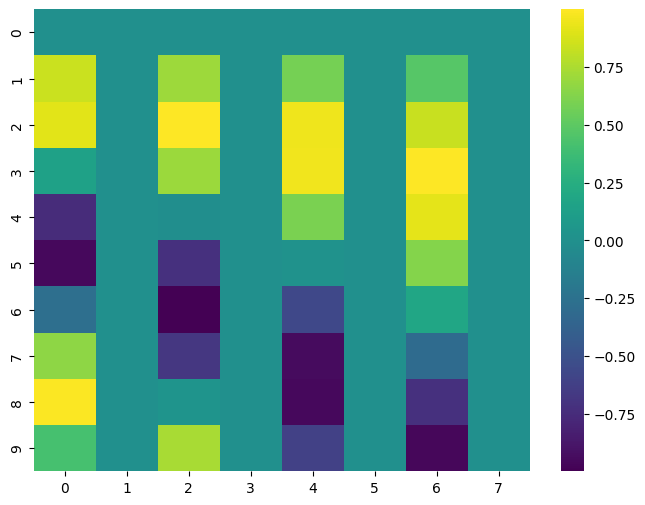

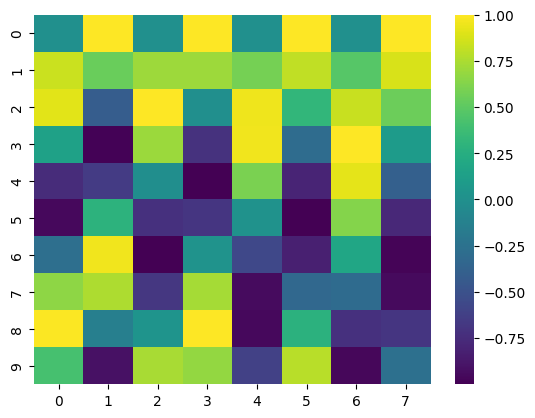

Positional encoding applied for our 3 timesteps


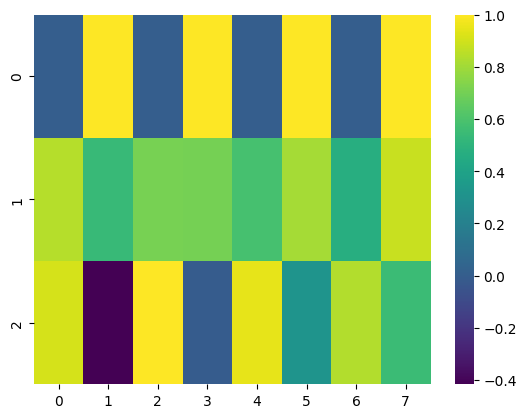

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import SymLogNorm

plt.figure(figsize=(8, 6))

xp = torch.zeros(10, 8)
maxlen = 10
position = torch.arange(0, 10).unsqueeze(1)
# print('position', position)
div_term = torch.exp(torch.arange(0, 8, 2)*(-math.log(9.0/8)))
# print('div_term', div_term)
xp[:, 0::2] = torch.sin(position.float() * div_term)
#evens
# print(xp)
# Generate the heatmap using seaborn
sns.heatmap(xp, cmap='viridis', annot=False)

# Display the plot
plt.show()
#odds
xp[:, 1::2] = torch.cos(position.float() * div_term)

sns.heatmap(xp, cmap='viridis', annot=False)

# Display the plot
plt.show()

print('Positional encoding applied for our 3 timesteps')
sns.heatmap(xp[:3], cmap='viridis', annot=False)

# Display the plot
plt.show()


### Here we define our PyTorch model.

BasicTransformerNetwork is the model class, it extends the Module class provided by Pytorch.
- We define \_\_init__() function. It sets up layers and defines the model parameters.
- Also, we define forward() function which defines how the forwared pass computation occurs



In [11]:
class BasicTransformerNetwork(torch.nn.Module):

    def __init__(self, seq_len, pred_len, enc_layer_dropout, pos_enc_dropout):
        # call the constructor of the base class
        super().__init__()
        self.model_type = 'Transformer'
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.num_features = num_features

        # I don't think the embedding size should be this big. We will see.
        self.embedding_size = 128 #The features are converted to 128 embeddings
        self.num_layers = num_layers
        self.pos_encoder = PositionalEncoding(self.embedding_size, pos_enc_dropout, 10000)

        # dim_feedforward = 4 * d_model
        # layer_norm_eps: A very small number (epsilon) added to the denominator during the Layer Normalization calculation.
        self.encLayer = torch.nn.TransformerEncoderLayer(d_model=self.embedding_size, nhead=8,
                                                 dim_feedforward=256, dropout=enc_layer_dropout, activation="relu",
                                                 layer_norm_eps=1e-05, batch_first=True)

        self.transformerEnc = torch.nn.TransformerEncoder(self.encLayer, num_layers=self.num_layers)

        self.input_fc = torch.nn.Linear(self.num_features, self.embedding_size)

        self.prediction_head = torch.nn.Linear(self.embedding_size, self.pred_len)

        # Create causal mask
        self.register_buffer('causal_mask', self._generate_causal_mask(seq_len))


    def _generate_causal_mask(self, seq_len):
        """
        Generate causal mask for transformer encoder.
        Returns upper triangular matrix with -inf in upper triangle (excluding diagonal)
        """
        mask = torch.triu(torch.full((seq_len, seq_len), float('-inf')), diagonal=1)
        return mask


    def forward(self, x):
        x = self.input_fc(x) * np.sqrt(self.embedding_size)
        x = self.pos_encoder(x)
        out = self.transformerEnc(x, mask=self.causal_mask)
        last_embedding = out[:, -1, :]
        prediction = self.prediction_head(last_embedding)
        prediction = prediction.squeeze(-1)
        return prediction
# Note that the gradients are stored inside the FC layer objects
# For each training example we need to get rid of these gradients

In [12]:
model = BasicTransformerNetwork(3, 1, 0.1, 0.1)

In [13]:
#input 4 x 7, batch size 4
x = torch.Tensor(np.random.random((4, 3, 7)))
x

tensor([[[0.3745, 0.9507, 0.7320, 0.5987, 0.1560, 0.1560, 0.0581],
         [0.8662, 0.6011, 0.7081, 0.0206, 0.9699, 0.8324, 0.2123],
         [0.1818, 0.1834, 0.3042, 0.5248, 0.4319, 0.2912, 0.6119]],

        [[0.1395, 0.2921, 0.3664, 0.4561, 0.7852, 0.1997, 0.5142],
         [0.5924, 0.0465, 0.6075, 0.1705, 0.0651, 0.9489, 0.9656],
         [0.8084, 0.3046, 0.0977, 0.6842, 0.4402, 0.1220, 0.4952]],

        [[0.0344, 0.9093, 0.2588, 0.6625, 0.3117, 0.5201, 0.5467],
         [0.1849, 0.9696, 0.7751, 0.9395, 0.8948, 0.5979, 0.9219],
         [0.0885, 0.1960, 0.0452, 0.3253, 0.3887, 0.2713, 0.8287]],

        [[0.3568, 0.2809, 0.5427, 0.1409, 0.8022, 0.0746, 0.9869],
         [0.7722, 0.1987, 0.0055, 0.8155, 0.7069, 0.7290, 0.7713],
         [0.0740, 0.3585, 0.1159, 0.8631, 0.6233, 0.3309, 0.0636]]])

In [14]:
model.forward(x)

tensor([-0.3471, -0.3335, -0.2145, -0.1214], grad_fn=<SqueezeBackward1>)

In [ ]:
print(torch.__version__)

2.2.1+cu121


In [15]:
learning_rate = 0.00005950
pos_enc_dropout = 0.11007
enc_layer_dropout = 0.194726
weight_decay = 0.000165

model = BasicTransformerNetwork(seq_len, pred_len, pos_enc_dropout, enc_layer_dropout)
model = model.to(device)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [16]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 266113


In [ ]:
for i, (f,l) in enumerate(train_loader):
    print('features shape: ', f.shape)
    print('labels shape: ', l.shape)
    break

features shape:  torch.Size([512, 13, 7])
labels shape:  torch.Size([512, 1])


In [17]:
# define metrics
import numpy as np
import matplotlib.pyplot as plt
epsilon = np.finfo(float).eps

def wape_function(y, y_pred):
    """Weighted Average Percentage Error metric in the interval [0; 100]"""
    y = np.array(y)
    y_pred = np.array(y_pred)
    nominator = np.sum(np.abs(np.subtract(y, y_pred)))
    denominator = np.add(np.sum(np.abs(y)), epsilon)
    wape = np.divide(nominator, denominator) * 100.0
    return wape

def nse_function(y, y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    return (1-(np.sum((y_pred-y)**2)/np.sum((y-np.mean(y))**2)))


def evaluate_model(model, data_loader, plot=False):
    # following line prepares the model for evaluation mode. It disables dropout and batch normalization if they have
    # are part of the model. For our simple model, it's not necessary. Still, we're going to use it.

    model.eval()
    all_outputs = torch.empty(0, pred_len)
    all_labels = torch.empty(0, pred_len)
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        with torch.no_grad():
            outputs = model(inputs).detach().cpu().unsqueeze(1)
        all_outputs = torch.vstack((all_outputs, outputs))
        all_labels = torch.vstack((all_labels, labels))

    avg_val_loss = loss(all_outputs, all_labels)
    nse = nse_function(all_labels.numpy(), all_outputs.numpy())
    wape = wape_function(all_labels.numpy(), all_outputs.numpy())

    print(f'NSE : {nse}', end=' ')
    print(f'WAPE : {wape}', end=' ')
    print(f'Validation Loss: {avg_val_loss}')

    model.train()

    if plot:
        plt.figure(figsize=(16, 6))
        plt.plot(np.array(all_labels.cpu()[:400]), color='green', label='observations')
        plt.plot(np.array(all_outputs.cpu()[:400]), color='red', linestyle='-', label='predictions')
        metrics_text = f"NSE: {nse:.3f}\nWAPE: {wape:.3f}"
        plt.text(0.28, 0.97, metrics_text, transform=plt.gca().transAxes,
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        plt.legend()
        plt.show()

    return avg_val_loss


In [18]:
num_epochs = 200
best_val_loss = float('inf')
patience = 5

for epoch in range(num_epochs):
    epoch_loss = []
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs).unsqueeze(1)
        loss_val = loss(outputs, labels)

        # calculate gradients for back propagation
        loss_val.backward()

        # update the weights based on the gradients
        optimizer.step()

        # reset the gradients, avoid gradient accumulation
        optimizer.zero_grad()
        epoch_loss.append(loss_val.item())

    avg_train_loss = sum(epoch_loss)/len(epoch_loss)
    print(f'Epoch {epoch+1}: Traning Loss: {avg_train_loss}', end=' ')
    avg_val_loss = evaluate_model(model, val_loader)

    # Check for improvement
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            # Load the best model before stopping
            model.load_state_dict(torch.load('best_model.pth'))
            break

Epoch 1: Traning Loss: 0.020138496495463815 NSE : 0.7754034996032715 WAPE : 24.405047243015748 Validation Loss: 0.003836776362732053
Epoch 2: Traning Loss: 0.004932089439525803 NSE : 0.8967824578285217 WAPE : 16.1737782650851 Validation Loss: 0.0017632626695558429
Epoch 3: Traning Loss: 0.0033223179399463074 NSE : 0.9355338215827942 WAPE : 12.924157438247526 Validation Loss: 0.001101273694075644
Epoch 4: Traning Loss: 0.0024673973771967136 NSE : 0.9535191655158997 WAPE : 10.986755480335196 Validation Loss: 0.0007940311334095895
Epoch 5: Traning Loss: 0.001998898393937222 NSE : 0.9553622603416443 WAPE : 10.878422965625305 Validation Loss: 0.0007625453872606158
Epoch 6: Traning Loss: 0.0016728114835820912 NSE : 0.9629586338996887 WAPE : 9.752413030253239 Validation Loss: 0.000632776296697557
Epoch 7: Traning Loss: 0.0014392543646827662 NSE : 0.9767181277275085 WAPE : 7.319972591165651 Validation Loss: 0.0003977238084189594
Epoch 8: Traning Loss: 0.0012408662291558453 NSE : 0.980374217033

NSE : 0.9110975116491318 WAPE : 13.922999532634064 Validation Loss: 0.0009707555873319507


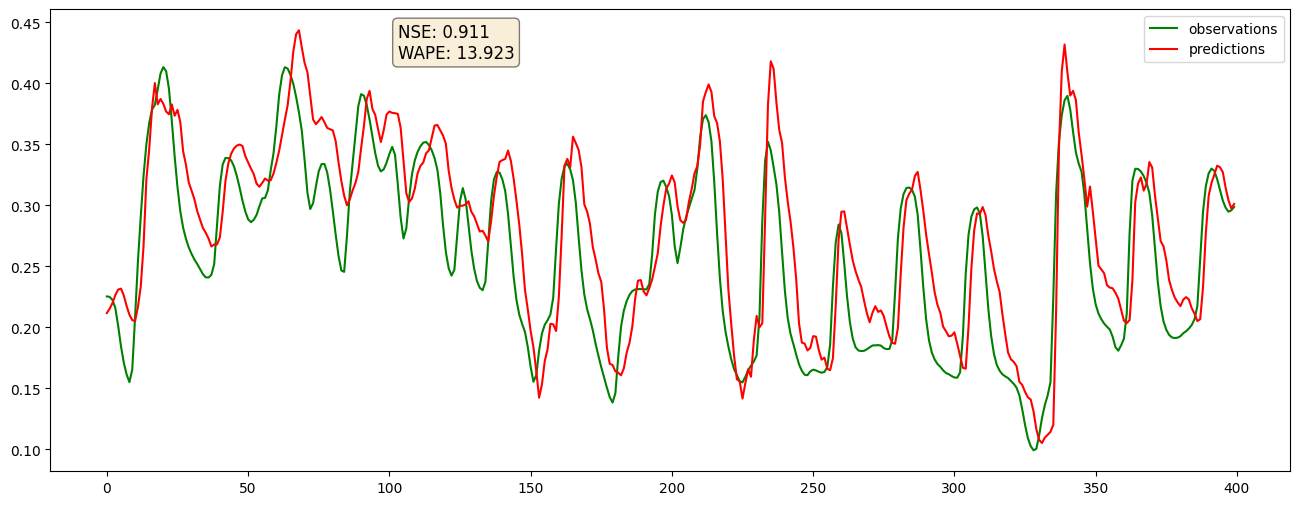

tensor(0.0010)

In [ ]:
evaluate_model(model, test_loader, plot=True)

In [19]:
# Plot the results with the metrics inside it